# TokenRing

## Цель работы

Целью работы является построение простой модели TokenRing и исследование его свойств: зависимости latency и throughput от количества нод и загрузки сети.

## Модель

TokenRing состоит из нод, образующих кольцо, и медиумов, соединяющих ноды. Нода может получать токен от предыдущей ноды и передавать его следующей через соответствующие медиумы. Токены не могут обгонять друг друга.

Каждая нода запускается в отдельном потоке. Нода случайно выбирает адресата и отправляет ему токен, записав в него время отправки. Получив токен обратно, нода сохраняет время получения и время прохождения токена по кольцу. После завершения работы все ноды отправляют собранную статистику в сервис статистики, после чего агрегированные данные сохраняются в файл.

Медиум реализован с помощью ArrayBlockingQueue с возможностью задавать размер очереди.

Под загрузкой сети подразумевается отношение количества токенов в сети к количеству нод.

Код модели выложен на GitHub: https://github.com/mrmegapolys/TokenRing. 

## Оборудование

Эксперименты проводились на MacBook Pro 2019 (2.6GHz 6-core Intel Core i7, HyperThreading on)

## Эксперименты

Первымы были проведены эксперименты по определению оптимального количества нод для имеющейся машины. Если бы ядер было бесконечное количество, то время прохождения токена по кольцу (latency) росло бы линейно с размером кольца, поэтому в качестве целевой была выбрана метрика latency per node. Ожидается, что при малом количестве нод она не должна зависеть от размера кольца, однако, при 6 нодах (количество физических ядер) или при 12 нодах (количество доступных потоков с учетом HyperThreading) характер зависимости должен измениться. 

На следующих графиках представлены зависимости latency per node от количества нод для разных значений загрузки сети при заданном размере очереди $queueSize=1$ (режим работы без возможности накопления токенов в медиуме).

Здесь и далее графики с несколькими зависимостями построены без отображения ошибок во избежание наложения шкал ошибок друг на друга.

In [ ]:
latency_vs_nodes_data = latency_vs_nodes_data()

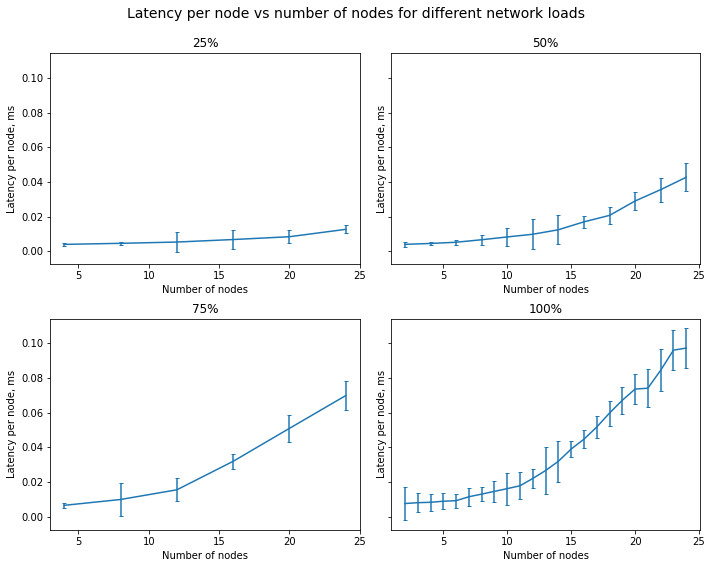

In [11]:
show_latency_vs_nodes(latency_vs_nodes_data)

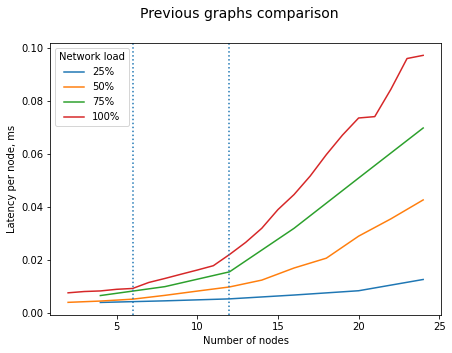

In [12]:
show_latency_vs_nodes_comparison(latency_vs_nodes_data)

На последнем графике пунктиром построены 2 вертикальные линии, соответствующие 6 и 12 нодам. Можно заметить, что в окрестности этих точек характер зависимости меняется на всех режимах работы сети: наилучшая производительность достигается при $N<6$, при $6<N<12$ производительность немного падает, а при $N>12$ latency per node начинает сильно расти, что говорит о неэффективном режиме работы.

Дальнейшие эксперименты будут проводиться при трех значениях размера кольца: 6, 10 и 12.

В следующем эксперименте были исследованы зависимости latency и throughput от размера очереди в медиуме. Гипотеза заключается в следующем: в первом эксперименте, где накопление токенов в медиуме было невозможно, случайная задержка в одной из нод могла сильно тормозить движение других токенов вплоть до полной остановки TokenRing в случае полной загрузки сети. Использование очереди в медиуме позволило бы другим токенам беспрепятственно двигаться по кольцу, что должно привести к увеличению производительности (падению latency и росту throughput). Максимальный размер очереди можно установить равным размеру кольца, так как позволяет всем токенам в кольце поместиться в одну очередь и дальнейшее увеличение размера очереди не имеет прямого влияния на механику движения токенов в кольце.

При этом ожидается, что, начиная с какого-то размера очереди, прирост производительности при дальнейшем увеличении размера очереди будет незначительным, так как большая часть случайных задержек будет скомпенсирована и производительность асимптотически выйдет на свое максимальное значение.

На следующих графиках построены зависимости latency от queueSize для трех значений размера кольца.

In [13]:
lat_thr_vs_queueSize_data_6 = lat_thr_vs_queueSize_data(6)
lat_thr_vs_queueSize_data_10 = lat_thr_vs_queueSize_data(10)
lat_thr_vs_queueSize_data_12 = lat_thr_vs_queueSize_data(12)

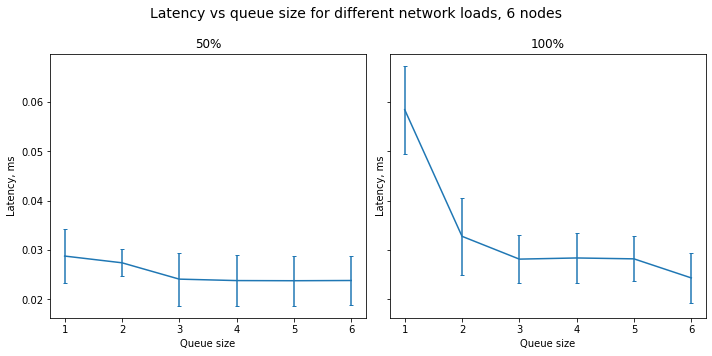

In [14]:
show_latency_vs_queueSize(lat_thr_vs_queueSize_data_6)

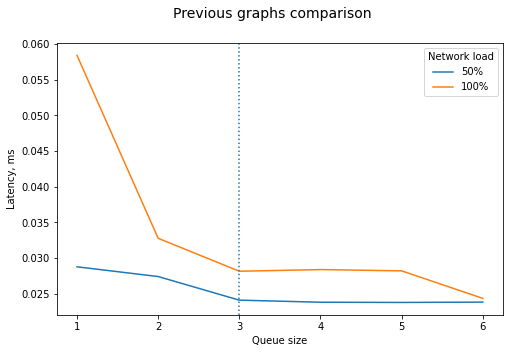

In [15]:
show_latency_vs_queueSize_comparison(lat_thr_vs_queueSize_data_6)

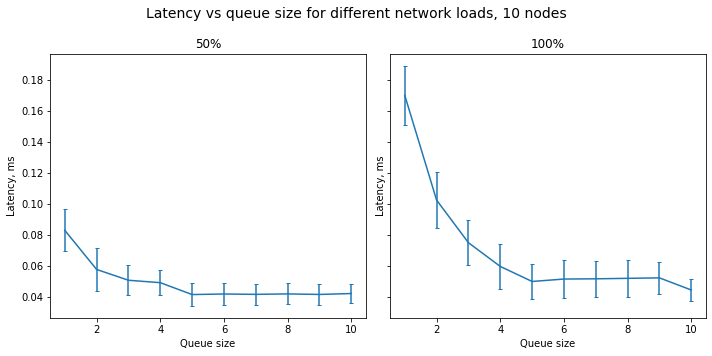

In [16]:
show_latency_vs_queueSize(lat_thr_vs_queueSize_data_10)

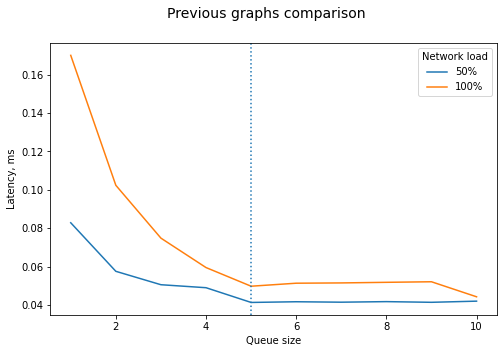

In [17]:
show_latency_vs_queueSize_comparison(lat_thr_vs_queueSize_data_10)

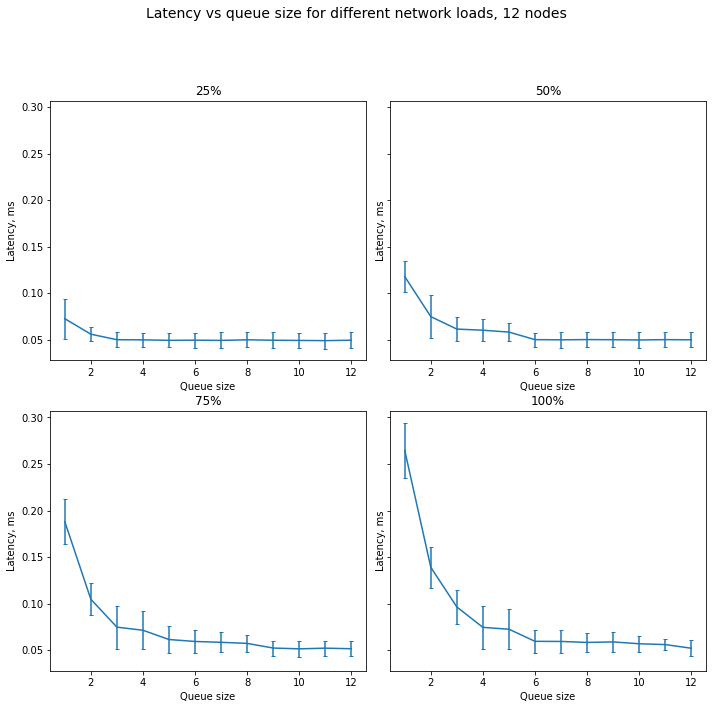

In [18]:
show_latency_vs_queueSize(lat_thr_vs_queueSize_data_12)

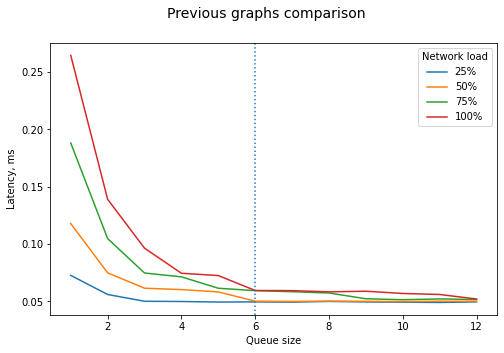

In [19]:
show_latency_vs_queueSize_comparison(lat_thr_vs_queueSize_data_12)

На графиках видно, что использование очереди позволяет сильно уменьшить latency, особенно при высокой загрузке сети. Также можно заметить, что на всех графиках latency перестает меняться, как только размер очереди становится равен количеству токенов в сети, что подтверждает сделанное выше предположение.

На графиках, где построены зависимости для всех значений загрузки сети, построена вертикальная линия с абсциссой, равной половине размера кольца. Видно, что для всех трех размеров кольца справа от этой линии роста производительности как такового не происходит, из этого можно сделать вывод, что сеть можно достаточно сильно оптимизировать, используя очереди размером в половину размера кольца.

Теперь посмотрим на соответствующие графики зависимости throughput от queueSize.

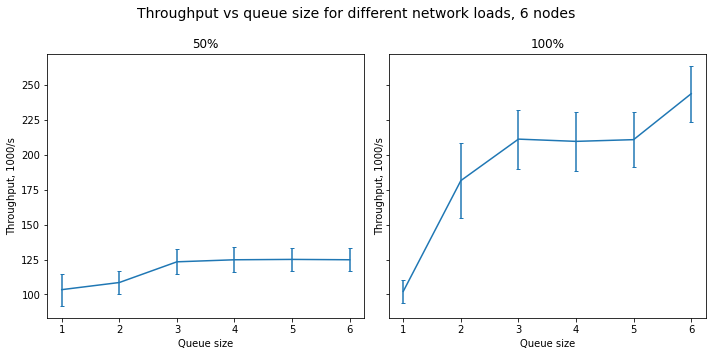

In [20]:
show_throughput_vs_queueSize(lat_thr_vs_queueSize_data_6)

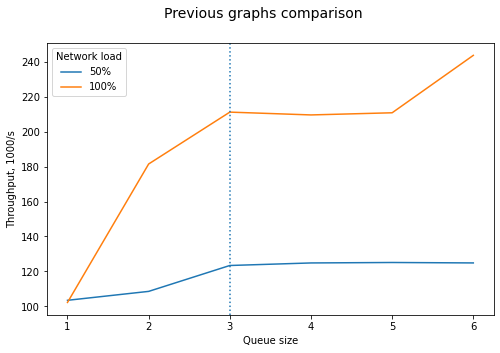

In [21]:
show_throughput_vs_queueSize_comparison(lat_thr_vs_queueSize_data_6)

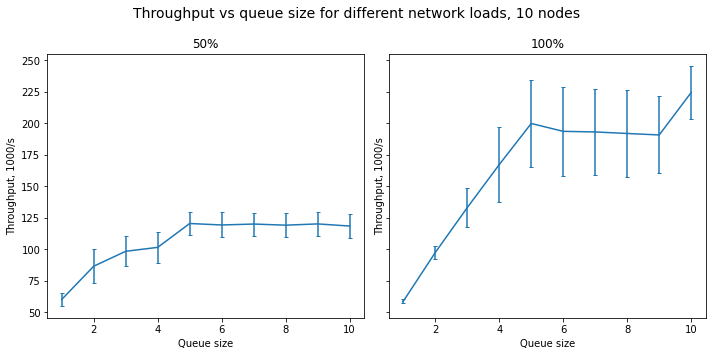

In [22]:
show_throughput_vs_queueSize(lat_thr_vs_queueSize_data_10)

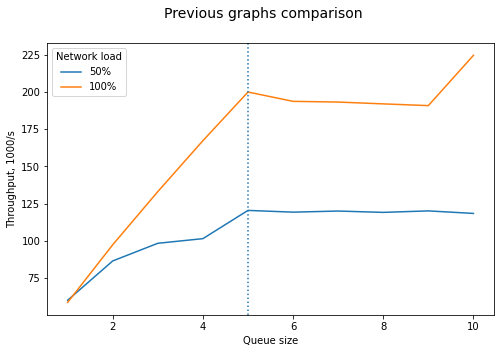

In [23]:
show_throughput_vs_queueSize_comparison(lat_thr_vs_queueSize_data_10)

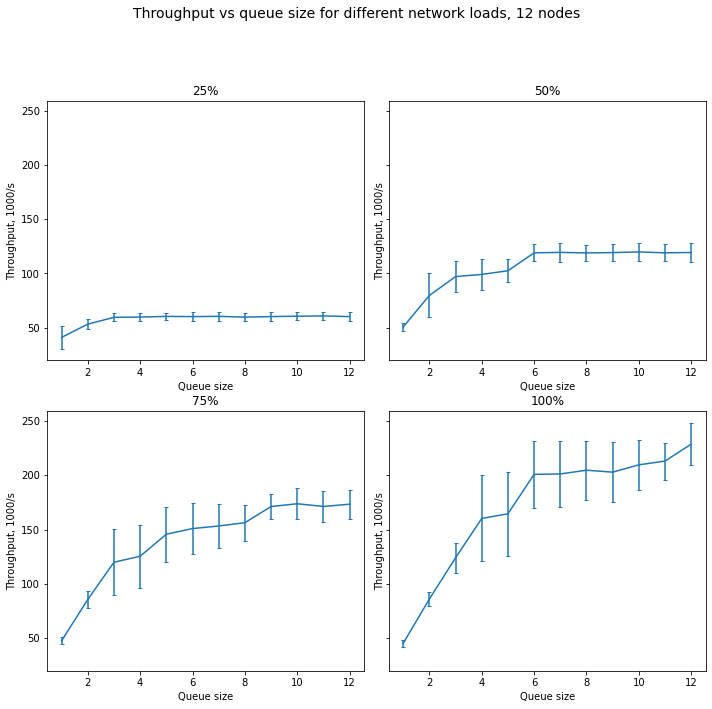

In [24]:
show_throughput_vs_queueSize(lat_thr_vs_queueSize_data_12)

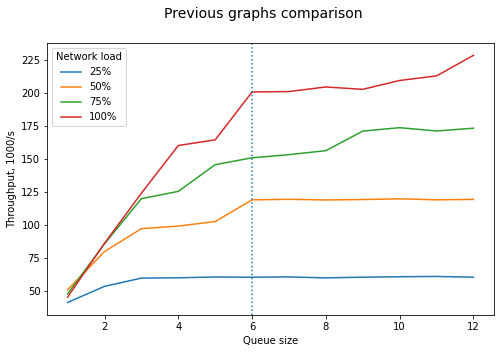

In [25]:
show_throughput_vs_queueSize_comparison(lat_thr_vs_queueSize_data_12)

Как и в случае с latency, видно, что использование очередей в медиумах значительно увеличивает производительность. При этом в случае с throughput производительность также перестает расти, как только размер очереди сравнивается с количеством токенов в сети. Более того, точно так же можно выделить 'оптимальный' размер очереди, равный половине размера кольца, использование которого позволяет получить практически такую же производительность, как и при использовании максимального размера очереди. Таким образом, все выводы, сделанные при исследовании latency, подтверждаются и измерениями throughput.

## Выводы

В этой работе был произведен анализ характеристик сети TokenRing, была произведена успешная попытка оптимизировать сеть и улучшить значения latency и throughput за счет использования очередей в медиумах. Было показано существование оптимального размера очереди в медиуме, равное половине размера кольца. Удивительным оказалось то, что это значение является оптимальным для всех размеров кольца, причем как с точки зрения latency, так и с точки зрения throughtput.

In [1]:
import json
import matplotlib.pyplot as plt
from collections import Counter
from statistics import mean, stdev

In [2]:
def extract_data(ringSize, tokens, delay, queueSize, gen):
    with open(f'gen{gen}/experiment_ringSize={ringSize},tokens={int(tokens)},delay={delay},queueSize={queueSize}.json', 'r') as f:
        raw_data = json.load(f)
        
    latencies, timestamps = [], []
    for entry in raw_data[100000:]:
        latencies.append(entry['rtt'] / 1_000_000)
        timestamps.append(entry['timestamp'] / 1_000_000)
        
    start = timestamps[0]
    clean_timestamps = [timestamp - start for timestamp in timestamps]
    
    return latencies, clean_timestamps

In [3]:
def latency_vs_nodes_data():    
    x_25, x_50, x_75, x_100 = [], [], [], []
    y_25, y_50, y_75, y_100 = [], [], [], []
    e_25, e_50, e_75, e_100 = [], [], [], []

    for size in range(2, 25):
        x_100.append(size)
        latencies, _ = extract_data(size, size, 0, 1, '3_cd')
        y_100.append(mean(latencies) / size)
        e_100.append(stdev(latencies) / size)
        if size % 2 == 0:
            x_50.append(size)
            latencies, _ = extract_data(size, size * 0.5, 0, 1, '3_cd')
            y_50.append(mean(latencies) / size)
            e_50.append(stdev(latencies) / size)
        if size % 4 == 0:
            x_25.append(size)
            x_75.append(size)
            latencies, _ = extract_data(size, size * 0.25, 0, 1, '3_cd')
            y_25.append(mean(latencies) / size)
            e_25.append(stdev(latencies) / size)
            latencies, _ = extract_data(size, size * 0.75, 0, 1, '3_cd')
            y_75.append(mean(latencies) / size)
            e_75.append(stdev(latencies) / size)
            
    return [x_25, y_25, e_25], [x_50, y_50, e_50], [x_75, y_75, e_75], [x_100, y_100, e_100]

In [4]:
def show_latency_vs_nodes(latency_vs_nodes_data):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
    axes[0, 0].errorbar(*latency_vs_nodes_data[0], capsize=2)
    axes[0, 0].set_title("25%")
    axes[0, 1].errorbar(*latency_vs_nodes_data[1], capsize=2)
    axes[0, 1].set_title("50%")
    axes[1, 0].errorbar(*latency_vs_nodes_data[2], capsize=2)
    axes[1, 0].set_title("75%")
    axes[1, 1].errorbar(*latency_vs_nodes_data[3], capsize=2)
    axes[1, 1].set_title("100%")
    for row in axes:
        for ax in row:
            ax.set_xlabel("Number of nodes")
            ax.set_ylabel("Latency per node, ms")
    plt.tight_layout()
    plt.suptitle("Latency per node vs number of nodes for different network loads", fontsize=14)
    plt.subplots_adjust(top=0.9)
    plt.setp(axes, xticks=range(5, 26, 5))
    plt.show()

In [5]:
def show_latency_vs_nodes_comparison(latency_vs_nodes_data):
    plt.figure(figsize=(7, 5))
    plt.plot(latency_vs_nodes_data[0][0], latency_vs_nodes_data[0][1], label="25%")
    plt.plot(latency_vs_nodes_data[1][0], latency_vs_nodes_data[1][1], label="50%")
    plt.plot(latency_vs_nodes_data[2][0], latency_vs_nodes_data[2][1], label="75%")
    plt.plot(latency_vs_nodes_data[3][0], latency_vs_nodes_data[3][1], label="100%")
    plt.axvline(x=12, linestyle="dotted")
    plt.axvline(x=6, linestyle="dotted")
    plt.xlabel("Number of nodes")
    plt.ylabel("Latency per node, ms")
    plt.legend(title="Network load")
    plt.suptitle("Previous graphs comparison", fontsize=14)
    plt.show()

In [6]:
def lat_thr_vs_queueSize_data(ringSize):
    def clean(latencies):
        return [latency for latency in latencies if latency < 0.5]
    
    def get_throughput(timestamps):
        prepared_timestamps = [timestamp // 10 for timestamp in timestamps]
        counter = Counter()
        for ts in prepared_timestamps:
            counter[ts] += 1
        return [item / 10 for item in counter.values()]
    
    x = []
    y_25_l, y_50_l, y_75_l, y_100_l = [], [], [], []
    e_25_l, e_50_l, e_75_l, e_100_l = [], [], [], []
    y_25_t, y_50_t, y_75_t, y_100_t = [], [], [], []
    e_25_t, e_50_t, e_75_t, e_100_t = [], [], [], []
    
    for size in range(1, ringSize + 1):
        x.append(size)
        
        latencies, timestamps = extract_data(ringSize, ringSize, 0, size, '5_cd_2')
        throughput = get_throughput(timestamps)
        y_100_t.append(mean(throughput))
        e_100_t.append(stdev(throughput))
        latencies = clean(latencies)
        y_100_l.append(mean(latencies))
        e_100_l.append(stdev(latencies))
        
        latencies, timestamps = extract_data(ringSize, ringSize * 0.5, 0, size, '5_cd_2')
        throughput = get_throughput(timestamps)
        y_50_t.append(mean(throughput))
        e_50_t.append(stdev(throughput))
        latencies = clean(latencies)
        y_50_l.append(mean(latencies))
        e_50_l.append(stdev(latencies))
        
        if ringSize % 4 == 0:
            latencies, timestamps = extract_data(ringSize, ringSize * 0.25, 0, size, '5_cd_2')
            throughput = get_throughput(timestamps)
            y_25_t.append(mean(throughput))
            e_25_t.append(stdev(throughput))
            latencies = clean(latencies)
            y_25_l.append(mean(latencies))
            e_25_l.append(stdev(latencies))

            latencies, timestamps = extract_data(ringSize, ringSize * 0.75, 0, size, '5_cd_2')
            throughput = get_throughput(timestamps)
            y_75_t.append(mean(throughput))
            e_75_t.append(stdev(throughput))
            latencies = clean(latencies)
            y_75_l.append(mean(latencies))
            e_75_l.append(stdev(latencies))
            
    return x, [
        [y_25_l, e_25_l], [y_50_l, e_50_l], [y_75_l, e_75_l], [y_100_l, e_100_l]
    ], [
        [y_25_t, e_25_t], [y_50_t, e_50_t], [y_75_t, e_75_t], [y_100_t, e_100_t]
    ]   

In [7]:
def show_data_vs_queueSize(x, data, ylabel, title):
    [y_25, e_25], [y_50, e_50], [y_75, e_75], [y_100, e_100] = data
    hasFour = len(y_25)
    
    if hasFour:
        fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
        axes[0, 0].errorbar(x, y_25, e_25, capsize=2)
        axes[0, 0].set_title("25%")
        axes[0, 1].errorbar(x, y_50, e_50, capsize=2)
        axes[0, 1].set_title("50%")
        axes[1, 0].errorbar(x, y_75, e_75, capsize=2)
        axes[1, 0].set_title("75%")
        axes[1, 1].errorbar(x, y_100, e_100, capsize=2)
        axes[1, 1].set_title("100%")
        for row in axes:
            for ax in row:
                ax.set_xlabel("Queue size")
                ax.set_ylabel(ylabel)
    else:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
        axes[0].errorbar(x, y_50, e_50, capsize=2)
        axes[0].set_title("50%")
        axes[1].errorbar(x, y_100, e_100, capsize=2)
        axes[1].set_title("100%")
        for ax in axes:
            ax.set_xlabel("Queue size")
            ax.set_ylabel(ylabel)
            
    plt.tight_layout()
    plt.suptitle(title, fontsize=14)
    plt.subplots_adjust(top=0.85)
    plt.show()     

In [8]:
def show_data_vs_queueSize_comparison(x, data, ylabel):
    [y_25, _], [y_50, _], [y_75, _], [y_100, _] = data
    hasFour = len(y_25)
    
    plt.figure(figsize=(8, 5))
    if hasFour: plt.plot(x, y_25, label="25%")
    plt.plot(x, y_50, label="50%")
    if hasFour: plt.plot(x, y_75, label="75%")
    plt.plot(x, y_100, label="100%")
    plt.axvline(x=len(x) // 2, linestyle="dotted")

    plt.xlabel("Queue size")
    plt.ylabel(ylabel)
    plt.legend(title="Network load")
    plt.suptitle("Previous graphs comparison", fontsize=14)

    plt.show();

In [9]:
def show_latency_vs_queueSize(data):
    x, latencies, _ = data
    show_data_vs_queueSize(x, latencies, "Latency, ms", f"Latency vs queue size for different network loads, {len(x)} nodes")
    
def show_latency_vs_queueSize_comparison(data):
    x, latencies, _ = data
    show_data_vs_queueSize_comparison(x, latencies, "Latency, ms")
    
def show_throughput_vs_queueSize(data):
    x, _, throughput = data
    show_data_vs_queueSize(x, throughput, "Throughput, 1000/s", f"Throughput vs queue size for different network loads, {len(x)} nodes")
    
def show_throughput_vs_queueSize_comparison(data):
    x, _, throughput = data
    show_data_vs_queueSize_comparison(x, throughput, "Throughput, 1000/s")    